# Unconstrained optimizer prototype

In [1]:
# Global Parameters
N = 10  # number of Fourier terms
kappa = 1  # permanent impact
lambda_ = 6  # temporary impact
xi_a = 0  # risk aversion of a
sigma = 0  # volatility of the stock
N_PLOT_POINTS = 100  # number of points for plotting

In [2]:
# Utility fourier math functions - this should really be in a separate file
import numpy as np
from scipy.integrate import quad
from typing import Callable, List, Tuple


def sin_coeff(func: Callable[[float], float], n: int,
              a: float = 0, b: float = 1) -> np.ndarray:
	""" Calculate coefficients of a sine series """
	coeffs = np.zeros(n)
	for i in range(1, n + 1):
		coeffs[i - 1] = quad(func, a, b, weight='sin', wvar=(i * np.pi))[0]
	return 2 * coeffs


def find_fourier_coefficients(functions: List[Callable[[float, float, float], float]],
                              kappa: float, lambda_: float, n: int, gamma: float = 1) -> List[np.ndarray]:
	all_coeffs = []
	for func in functions:
		coeffs = sin_coeff(lambda t: (func(t, kappa, lambda_) - t * gamma), n)
		all_coeffs.append(coeffs)
	return all_coeffs


def reconstruct_from_sin(t: float, coeffs: np.ndarray, n: [int | None] = None) -> float:
	"""
    Reconstructs the function value at a given point `t` from a vector of sine coefficients.

    :param t: The point at which to evaluate the reconstructed function.
    :param coeffs: An array of sine coefficients.
    :param n: The number of sine terms to use in the reconstruction. If None or greater than the length of `coeffs`,
              all coefficients are used.
    :return: The reconstructed function value at the point `t`.

    Notes:
    ------
    The function reconstructs the value by summing the sine series up to the `n`-th term.
    If `n` is not specified or exceeds the length of `coeffs`, it defaults to using all available coefficients.
    """
	reconstruction = 0  # Add the linear term t separately
	if n is None or n > len(coeffs):
		n = len(coeffs)
	for i in range(1, n + 1):
		reconstruction += coeffs[i - 1] * np.sin(i * np.pi * t)
	return reconstruction


def reconstruct_deriv_from_sin(t: float, coeffs: np.ndarray, n: [int | None] = None, order: int = 1) -> float:
	"""
    Reconstructs the nth derivative of the function value at a given point `t` from a vector of sine coefficients.

    :param t: The point at which to evaluate the reconstructed function.
    :param coeffs: An array of sine coefficients.
    :param n: The number of sine terms to use in the reconstruction. If None or greater than the length of `coeffs`,
              all coefficients are used.
    :param order: The order of the derivative to reconstruct.
    :return: The reconstructed nth derivative of the function value at the point `t`.

    Notes:
    ------
    The function reconstructs the nth derivative by summing the sine series up to the `n`-th term and applying the
    appropriate derivative formula for sine functions.
    If `n` is not specified or exceeds the length of `coeffs`, it defaults to using all available coefficients.
    """
	reconstruction = 0
	if n is None or n > len(coeffs):
		n = len(coeffs)
	for i in range(1, n + 1):
		reconstruction += coeffs[i - 1] * (i * np.pi) ** order * np.sin(i * np.pi * t + order * np.pi / 2)
	return reconstruction

Initial a_coeffs = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Initial guess cost = 8.4951

optimization time = 1.0471s
Optimized a_coeffs = [ 1.75  -0.531  0.214 -0.103  0.057 -0.034  0.022 -0.015  0.011 -0.008]
Optimized cost = -15.9366


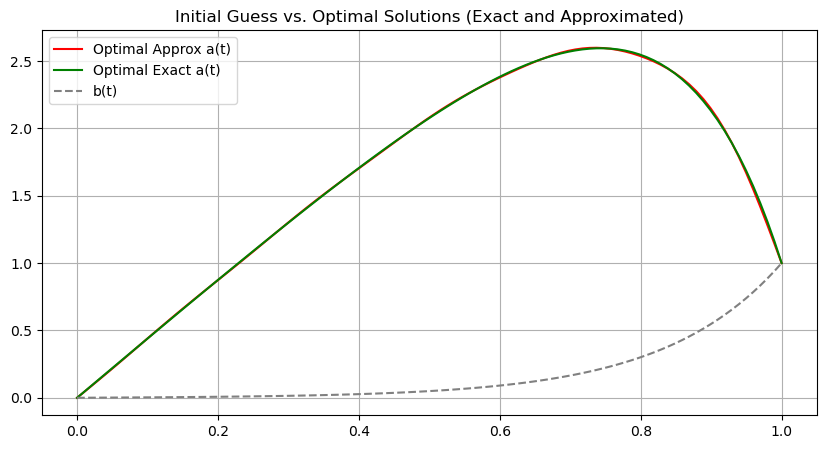

Approx - Exact Distance: L2 = 0.0695, max = 0.0273


In [5]:
"""
Miminize cost function over all trading schedules a(t) given b
"""
from scipy.optimize import minimize
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
import time


def b_func(t, kappa, lambda_, gamma=1):
	# return gamma * t ** 0.1
	return gamma * np.sinh(lambda_ * t) / np.sinh(lambda_)


def b_dot_func(t, kappa, lambda_, gamma=1):
	# return gamma * 0.1 * t ** (-0.9)
	return gamma * lambda_ * np.cosh(lambda_ * t) / np.sinh(lambda_)


def b_dbl_dot_func(t, kappa, lambda_, gamma=1):
	return gamma * lambda_ * lambda_ * np.sinh(lambda_ * t) / np.sinh(lambda_)


def b_vector(t):
	return (
		b_func(t, kappa, lambda_),
		b_dot_func(t, kappa, lambda_),
		b_dbl_dot_func(t, kappa, lambda_)
	)


def compute_exact_cost(a_func, a_dot_func, kappa, lambda_, verbose=False):
	def integrand_temp(t):
		_a_dot = a_dot_func(t, kappa, lambda_)
		_b_dot = b_dot_func(t, kappa, lambda_)
		return (_a_dot + lambda_ * _b_dot) * _a_dot

	def integrand_perm(t):
		_a = a_func(t, kappa, lambda_)
		_b = b_func(t, kappa, lambda_)
		_a_dot = a_dot_func(t, kappa, lambda_)
		return kappa * (_a + lambda_ * _b) * _a_dot

	temp_cost = quad(integrand_temp, 0, 1)[0]
	perm_cost = quad(integrand_perm, 0, 1)[0]

	if verbose:
		print("Exact temp_cost: ", temp_cost)
		print("Exact perm_cost: ", perm_cost)

	return temp_cost + perm_cost


def cost_function(a_coeffs):
	def a_func(t, kappa, lambda_, gamma=1):
		return reconstruct_from_sin(t, a_coeffs) + gamma * t

	def a_dot_func(t, kappa, lambda_, gamma=1):
		return reconstruct_deriv_from_sin(t, a_coeffs) + gamma

	return compute_exact_cost(a_func, a_dot_func, kappa, lambda_)


def plot_curves(init_guess, opt_coeffs, exact_solution, gamma=1) -> dict:
    """ Plot curves and and calc stats """
    t_values = np.linspace(0, 1, N_PLOT_POINTS)
    
    init_curve = [reconstruct_from_sin(t, init_guess) + gamma * t for t in t_values]
    opt_curve = [reconstruct_from_sin(t, opt_coeffs) + gamma * t for t in t_values]
    b_curve = [b_func(t, kappa, lambda_) for t in t_values]
    
    # Plot initial guess and optimized functions
    plt.figure(figsize=(10, 5))
    
    # plt.plot(t_values, init_curve, label='Initial guess', color='blue')
    plt.plot(t_values, opt_curve, label='Optimal Approx a(t)', color='red')
    plt.plot(t_values, exact_solution, label="Optimal Exact a(t)", color="green")
    plt.plot(t_values, b_curve, label="b(t)", color="grey", linestyle="dashed")
    plt.title(f'Initial Guess vs. Optimal Solutions (Exact and Approximated)')
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate stats
    diff_approx = opt_curve - exact_solution
    max_diff = np.max(np.abs(diff_approx))
    l2_diff = np.sqrt(diff_approx @ diff_approx)

    return {'max': max_diff, 'L2': l2_diff}

# Define the system of differential equations with exogenous b(t)
def equations(t, y, xi_a):
	a, a_prime = y
	b, b_prime, b_dbl_prime = b_vector(t)
	a_double_prime = -(lambda_ / 2) * (b_dbl_prime + kappa * b_prime) + xi_a * sigma ** 2 * a
	return np.vstack((a_prime, a_double_prime))


# Boundary conditionss
def boundary_conditions(ya, yb):
	return np.array([ya[0], yb[0] - 1])


if __name__ == "__main__":
	# Initial guess for a_coeffs
	initial_guess = np.zeros(N)
	initial_cost = cost_function(initial_guess)
	print(f"Initial a_coeffs = {np.round(initial_guess,3)}")
	print(f"Initial guess cost = {initial_cost:.4f}\n")

	# Minimize the cost function
	start = time.time()
	result = minimize(cost_function, initial_guess)
	print(f"optimization time = {(time.time() - start):.4f}s")

	# Optimized coefficients
	optimized_a_coeffs = result.x

	# Compute the cost with optimized coefficients
	optimized_cost = cost_function(optimized_a_coeffs)

	print(f"Optimized a_coeffs = {np.round(optimized_a_coeffs,3)}")
	print(f"Optimized cost = {optimized_cost:.4f}")

	# Find the exact solution
	t = np.linspace(0, 1, N_PLOT_POINTS)
	y_init = np.zeros((2, t.size))
	sol = solve_bvp(lambda _t, y: equations(_t, y, xi_a), boundary_conditions, t, y_init)

	# Plot curves
	stats = plot_curves(initial_guess, optimized_a_coeffs, sol.y[0])
	print(f"Approx - Exact Distance: L2 = {stats['L2']:.4f}, max = {stats['max']:.4f}")